In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pwlf
import pathlib
import math
import numpy as np

In [77]:
src = pathlib.Path().cwd().parent.parent / 'data' / 'processed'

In [88]:
no_death = pd.read_csv(src / 'no-death' / 'no-death.csv', index_col=0)
no_death_by_adh = pd.read_csv(src / 'no-death-by-group' / 'no-death-by-adh.csv')
no_death_by_ag = pd.read_csv(src / 'no-death-by-group' / 'no-death-by-ag.csv')
no_death_by_sex = pd.read_csv(src / 'no-death-by-group' / 'no-death-by-sex.csv')

In [89]:
no_death.index = pd.to_datetime(no_death.index)
no_death_by_adh.date_report = pd.to_datetime(no_death_by_adh.date_report)
no_death_by_ag.date_report = pd.to_datetime(no_death_by_ag.date_report)
no_death_by_sex.date_report = pd.to_datetime(no_death_by_sex.date_report)

In [20]:
# shift left
# no_death['no_death_rollmean7d_sl'] = no_death.no_death_rollmean7d.shift()
# no_death = no_death.loc[:'2021-08-20',]

In [92]:
no_death.tail()
no_death_by_adh[(no_death_by_adh.date_report >= '2021-08-10')
                & (no_death_by_adh.date_report <= '2021-08-15')
                & (no_death_by_adh.addr_dist_home == 'QUAN 10')]

,date_report,no_death,no_death_rollmean7d,no_death_cumsum,no_death_ppop,no_death_ppop_rollmean7d,no_death_ppop_cumsum,addr_dist_home
1352,2021-08-10,9,9.571429,168,3.833,4.076000,71.547,QUAN 10
1373,2021-08-11,6,9.285714,174,2.555,3.954286,74.102,QUAN 10
1394,2021-08-12,6,8.142857,180,2.555,3.467571,76.657,QUAN 10
1415,2021-08-13,7,8.285714,187,2.981,3.528429,79.638,QUAN 10
1436,2021-08-14,6,7.000000,193,2.555,2.980857,82.193,QUAN 10
1457,2021-08-15,10,7.857143,203,4.259,3.346000,86.452,QUAN 10


In [30]:
# Plot no_death
# fig, ax = plt.subplots(figsize=(20, 8))
# ax.plot(no_death.index, no_death.no_death_rollmean7d, linewidth=3, color='red', alpha=0.6)
# ax.set_ylabel('So tu vong')
# ax.set_ylim([0, 7500])
# ax.set_xlabel('Ngay')
# ax.set_xticks(no_death.index)
# ax.tick_params(axis='x', labelrotation=90)

In [31]:
# Plot log no_death
# fig, ax = plt.subplots(figsize=(16, 8))
# ax.plot(no_death.index, (no_death.no_death_rollmean7d).transform(np.log), linewidth=3, color='red', alpha=0.6)
# ax.set_ylabel('So tu vong')
# ax.set_ylim([0, 7500])
# ax.set_xlabel('Ngay')
# ax.set_xticks(no_death.index)
# ax.tick_params(axis='x', labelrotation=90)

In [93]:
# Model config
beta_dict = {}
slope_dict = {}
x_dict = {}
y_dict = {}
x_hat_dict = {}
y_hat_dict = {}
predicted_var_dict = {}
ub_dict = {}
lb_dict = {}
xlabels_dict = {}
plot_title_dict = {}
no_death_col = 'no_death_rollmean7d'
forecast_horizon = 14
policy_change = [no_death.index.min(),
#                  '2021-05-31',
#                  '2021-06-14',
                 '2021-06-19', 
                 '2021-07-09', 
                 '2021-07-19', 
                 '2021-07-27', # ngung xn hang loat
                 '2021-08-01', # chi thi 16
                 '2021-08-10', 
                 '2021-08-15',
#                  '2021-08-23',
                 no_death.index.max()
                ]

In [94]:
# Forecast no_death
# forecast_horizon = 15
# policy_change = [no_death.index.min(), '2021-05-31', '2021-06-14', '2021-06-19', 
#                  '2021-07-09', '2021-07-19', '2021-08-01', no_death.index.max()]

x = (no_death.index - no_death.index.min()) / pd.Timedelta(1, unit='d')
y = no_death[no_death_col].replace(0, np.nan).transform(np.log).fillna(0)
x0 = (pd.to_datetime(policy_change) - no_death.index.min()) / pd.Timedelta(1, unit='d')
xlabels = pd.date_range(
    no_death.index.min(),
    no_death.index.max() + pd.Timedelta(days=forecast_horizon-1)
).strftime('%d-%m')

model = pwlf.PiecewiseLinFit(x, y)
model.fit_with_breaks(x0)

x_hat = np.arange(min(x), max(x) + forecast_horizon)
y_hat = model.predict(x_hat)

predicted_var = model.prediction_variance(x_hat)
ub = y_hat + 1.96*np.sqrt(predicted_var)
lb = y_hat - 1.96*np.sqrt(predicted_var)

# Add result to dict
beta_dict['tphcm'] = list(model.beta)
slope_dict['tphcm'] = list(model.calc_slopes())
x_dict['tphcm'] = list(x)
y_dict['tphcm'] = list(y)
x_hat_dict['tphcm'] = list(x_hat)
y_hat_dict['tphcm'] = list(y_hat)
predicted_var_dict['tphcm'] = list(predicted_var)
ub_dict['tphcm'] = list(ub)
lb_dict['tphcm'] = list(lb)
xlabels_dict['tphcm'] = list(xlabels)
plot_title_dict['tphcm'] = 'TP HCM'

In [34]:
# no_death.index

In [95]:
# dir(model)
# slope_dict
model.r_squared()

0.979989492977583

In [36]:
# beta_dict['tphcm']

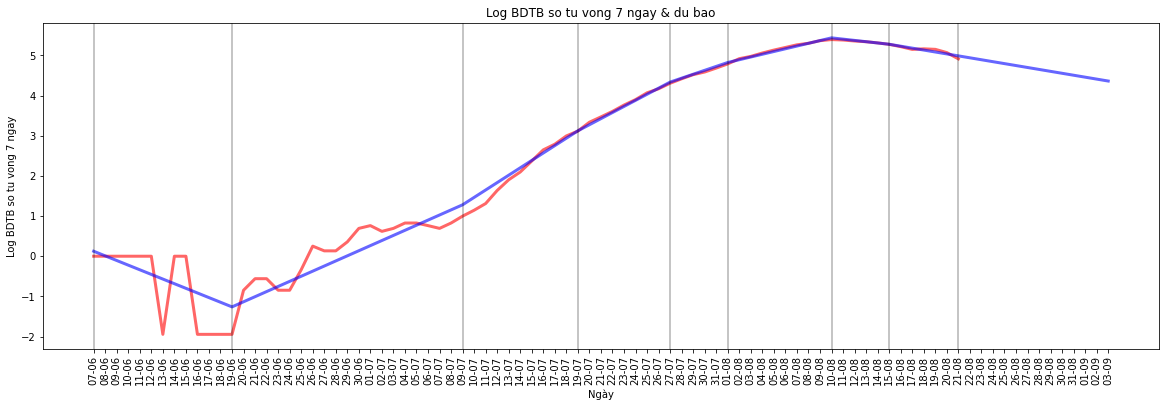

In [96]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(x, y, linewidth=3, color='red', alpha=0.6)
ax.plot(x_hat, y_hat, linewidth=3, color='blue', alpha=0.6)
# ax.plot(x_hat, ub, linewidth=2, color='blue', alpha=0.3)
# ax.plot(x_hat, lb, linewidth=2, color='blue', alpha=0.3)
ax.set_ylabel('Log BDTB so tu vong 7 ngay')
ax.set_xlabel('Ngày')
ax.set_title('Log BDTB so tu vong 7 ngay & du bao')
for i in x0:
    ax.axvline(i, color='black', alpha=0.3)

xlabels = pd.date_range(
    no_death.index.min(),
    no_death.index.max() + pd.Timedelta(days=forecast_horizon - 1)
).strftime('%d-%m')
ax.set_xticks(x_hat)
ax.set_xticklabels(xlabels)
ax.tick_params(axis='x', labelrotation=90)

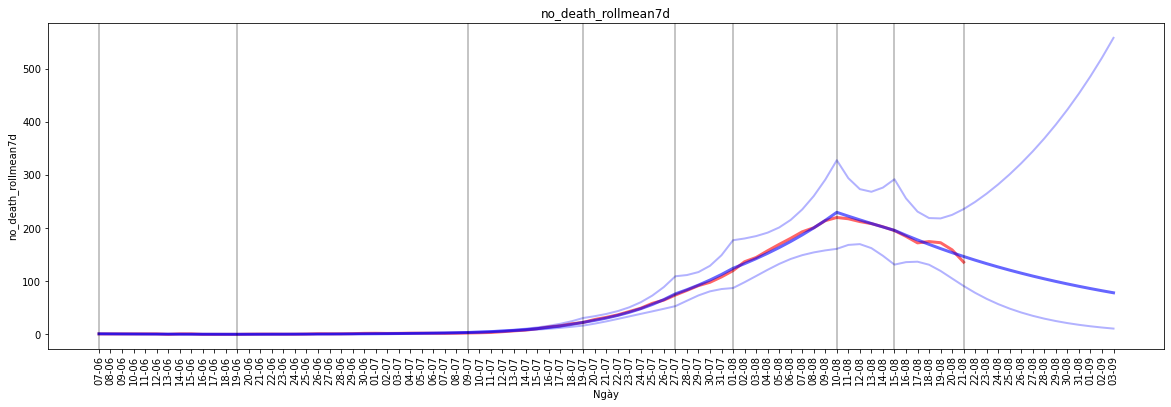

In [106]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(x, np.exp(y), linewidth=3, color='red', alpha=0.6)
ax.plot(x_hat,  np.exp(y_hat), linewidth=3, color='blue', alpha=0.6)
ax.plot(x_hat,  np.exp(ub), linewidth=2, color='blue', alpha=0.3)
ax.plot(x_hat,  np.exp(lb), linewidth=2, color='blue', alpha=0.3)
ax.set_ylabel(no_death_col)
ax.set_title(no_death_col)
for i in x0:
    ax.axvline(i, color='black', alpha=0.3)
ax.set_xlabel('Ngày')
xlabels = pd.date_range(
    no_death.index.min(),
    no_death.index.max() + pd.Timedelta(days=forecast_horizon -1 )
).strftime('%d-%m')
ax.set_xticks(x_hat)
ax.set_xticklabels(xlabels)
ax.tick_params(axis='x', labelrotation=90)
# ax.set_ylim([0, 10000])

In [39]:
# np.exp(y_hat_dict['tphcm'][95])
# np.exp(ub_dict['tphcm'][95])
# np.exp(lb_dict['tphcm'][95])
# xlabels_dict['tphcm'][100]
# rs = model.r_squared()
# rs

In [40]:
# no_case_by_adh[(no_case_by_adh.addr_dist_home == 'HUYEN BINH CHANH')
#                & (no_case_by_adh.date_report > '2021-06-30')]
# foo['no_case_rollmean7d_sl'] = foo.no_case_rollmean7d.shift(-10)
# foo = foo.set_index('date_report')
# foo = foo.loc[:'2021-08-11',]
# foo.tail(15)
# foo = list(no_case_by_adh['addr_dist_home'].unique())
# foo = foo.sort()
# sorted(foo)

In [104]:
# Forecast log no_death by adh
def forecast_no_death_by_group(data, group, no_death_col, forecast_horizon=7):
    unique = list(data[group].unique())
    for u in unique:
        df = data[data[group] == u]
#         df['no_death_rollmean7d_sl'] = df.no_death_rollmean7d.shift(-20) # for shift data only
        df['date_report'] = pd.to_datetime(df.date_report)
        df = df.set_index('date_report')
#         df = df.loc[:'2021-08-01',] # for shift data only
#         df.loc[:,'date_report'] = pd.to_datetime(df.index)
        key = str(u).lower().replace(' ', '')
#     output_dir = src / 'predicted-no-case-from-no-case-data'
#     prefix_1 = 'predicted-log-no-case-'
#     prefix_2 = 'by-adh-'
#     filename = prefix_1 + prefix_2 + u.lower().replace(' ', '') + '.png'
        # Run model PiecewiseLinFit with policy_change break
        x = (df.index - df.index.min()) / pd.Timedelta(1, unit='d')
        y = df[no_death_col].replace(0, np.nan).transform(math.log).fillna(0)
        x0 = (pd.to_datetime(policy_change) - df.index.min()) / pd.Timedelta(1, unit='d')
        xlabels = pd.date_range(
            df.index.min(),
            df.index.max() + pd.Timedelta(days=forecast_horizon-1)
        ).strftime('%d-%m')
        model = pwlf.PiecewiseLinFit(x, y)
        model.fit_with_breaks(x0)
        x_hat = np.arange(min(x), max(x) + forecast_horizon)
        y_hat = model.predict(x_hat)
        predicted_var = model.prediction_variance(x_hat)
        ub = y_hat + 1.96*np.sqrt(predicted_var)
        lb = y_hat - 1.96*np.sqrt(predicted_var)
        # Save result to dict
        beta_dict[key] = list(model.beta)
        slope_dict[key] = list(model.calc_slopes())
        x_dict[key] = list(x)
        y_dict[key] = list(y)
        x_hat_dict[key] = list(x_hat)
        y_hat_dict[key] = list(y_hat)
        predicted_var_dict[key] = list(predicted_var)
        ub_dict[key] = list(ub)
        lb_dict[key] = list(lb)
        xlabels_dict[key] = list(xlabels)
        plot_title_dict[key] = u

def plot_forecast_no_death_by_group(exp=True, sharex=True, nrow=8, ncol=3, 
                                   xstart=1, xend=25, ylim=700, figsize=(16, 20)):
    fig, ax = plt.subplots(nrow, ncol, figsize=figsize)
    plt.tight_layout(h_pad=5)
#     fig.suptitle('Title here')
    keys = sorted(list(x_dict.keys())[xstart:xend])
    if exp:
        for k in range(len(keys)):
            r = k // ncol
            c = k % ncol
            ax[r, c].plot(x_dict[keys[k]], np.exp(y_dict[keys[k]]), linewidth=2, color='red', alpha=0.6)
            ax[r, c].plot(x_hat_dict[keys[k]], np.exp(y_hat_dict[keys[k]]), linewidth=2, color='blue', alpha=0.6)
            ax[r, c].plot(x_hat_dict[keys[k]], np.exp(ub_dict[keys[k]]), linewidth=1, color='blue', alpha=0.3)
            ax[r, c].plot(x_hat_dict[keys[k]], np.exp(lb_dict[keys[k]]), linewidth=1, color='blue', alpha=0.3)
            ax[r, c].fill_between(x_hat_dict[keys[k]], np.exp(lb_dict[keys[k]]), np.exp(ub_dict[keys[k]]),
                                  color='blue', alpha=0.1)
            ax[r, c].title.set_text(plot_title_dict[keys[k]])
            ax[r, c].set_ylim([0, ylim])
    #         ax[r, c].set_ylabel('Log So tu vong')
    #         ax[r, c].set_xlabel('Ngày')
            ax[r, c].set_xticks(x_hat_dict[keys[k]])
            ax[r, c].set_xticklabels(xlabels_dict[keys[k]])
            ax[r, c].tick_params(axis='x', labelrotation=90)
            ax[r, c].locator_params(tight=True, nbins=11)

    else:
        for k in range(len(keys)):
            r = k // ncol
            c = k % ncol
            ax[r, c].plot(x_dict[keys[k]], y_dict[keys[k]], linewidth=2, color='red', alpha=0.6)
            ax[r, c].plot(x_hat_dict[keys[k]], y_hat_dict[keys[k]], linewidth=2, color='blue', alpha=0.6)
            ax[r, c].plot(x_hat_dict[keys[k]], ub_dict[keys[k]], linewidth=1, color='blue', alpha=0.3)
            ax[r, c].plot(x_hat_dict[keys[k]], lb_dict[keys[k]], linewidth=1, color='blue', alpha=0.3)
            ax[r, c].fill_between(x_hat_dict[keys[k]], lb_dict[keys[k]], ub_dict[keys[k]], color='blue', alpha=0.1)
            ax[r, c].title.set_text(plot_title_dict[keys[k]])
            ax[r, c].set_ylim([0, ylim])
            ax[r, c].set_xticks(x_hat_dict[keys[k]])
            ax[r, c].set_xticklabels(xlabels_dict[keys[k]])
            ax[r, c].tick_params(axis='x', labelrotation=90)
            ax[r, c].locator_params(tight=True, nbins=11)
        
# DO NOT DELETE THIS
#     fig, ax = plt.subplots(figsize=(20, 6))
#     ax.plot(x, y, linewidth=3, color='red', alpha=0.6)
#     ax.plot(x_hat, y_hat, linewidth=3, color='blue', alpha=0.6)
#     ax.plot(x_hat, ub, linewidth=2, color='blue', alpha=0.3)
#     ax.plot(x_hat, lb, linewidth=2, color='blue', alpha=0.3)
#     ax.set_ylabel('Log Số ca mới')
#     ax.set_xlabel('Ngày')
#     ax.set_xticks(x_hat)
#     ax.set_xticklabels(xlabels)
#     ax.tick_params(axis='x', labelrotation=90)
#     ax.set_title('Log số ca mới & Log số ca mới dự báo ' + u)
#     for i in x0:
#         ax.axvline(i, color='black', alpha=0.3)

#     plt.savefig(
#         output_dir / filename,
#         transparent = True)
#     plt.close(fig)



In [98]:
list(no_death_by_adh['addr_dist_home'].unique())

['QUAN 01',
 'QUAN 12',
 'QUAN GO VAP',
 'QUAN BINH THANH',
 'QUAN TAN BINH',
 'QUAN TAN PHU',
 'QUAN PHU NHUAN',
 'QUAN 03',
 'QUAN 10',
 'QUAN 11',
 'QUAN 04',
 'QUAN 05',
 'QUAN 06',
 'QUAN 08',
 'QUAN BINH TAN',
 'QUAN 07',
 'HUYEN CU CHI',
 'HUYEN HOC MON',
 'HUYEN BINH CHANH',
 'HUYEN NHA BE',
 'HUYEN CAN GIO']

<ipython-input-104-71ab05de2b37>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_report'] = pd.to_datetime(df.date_report)


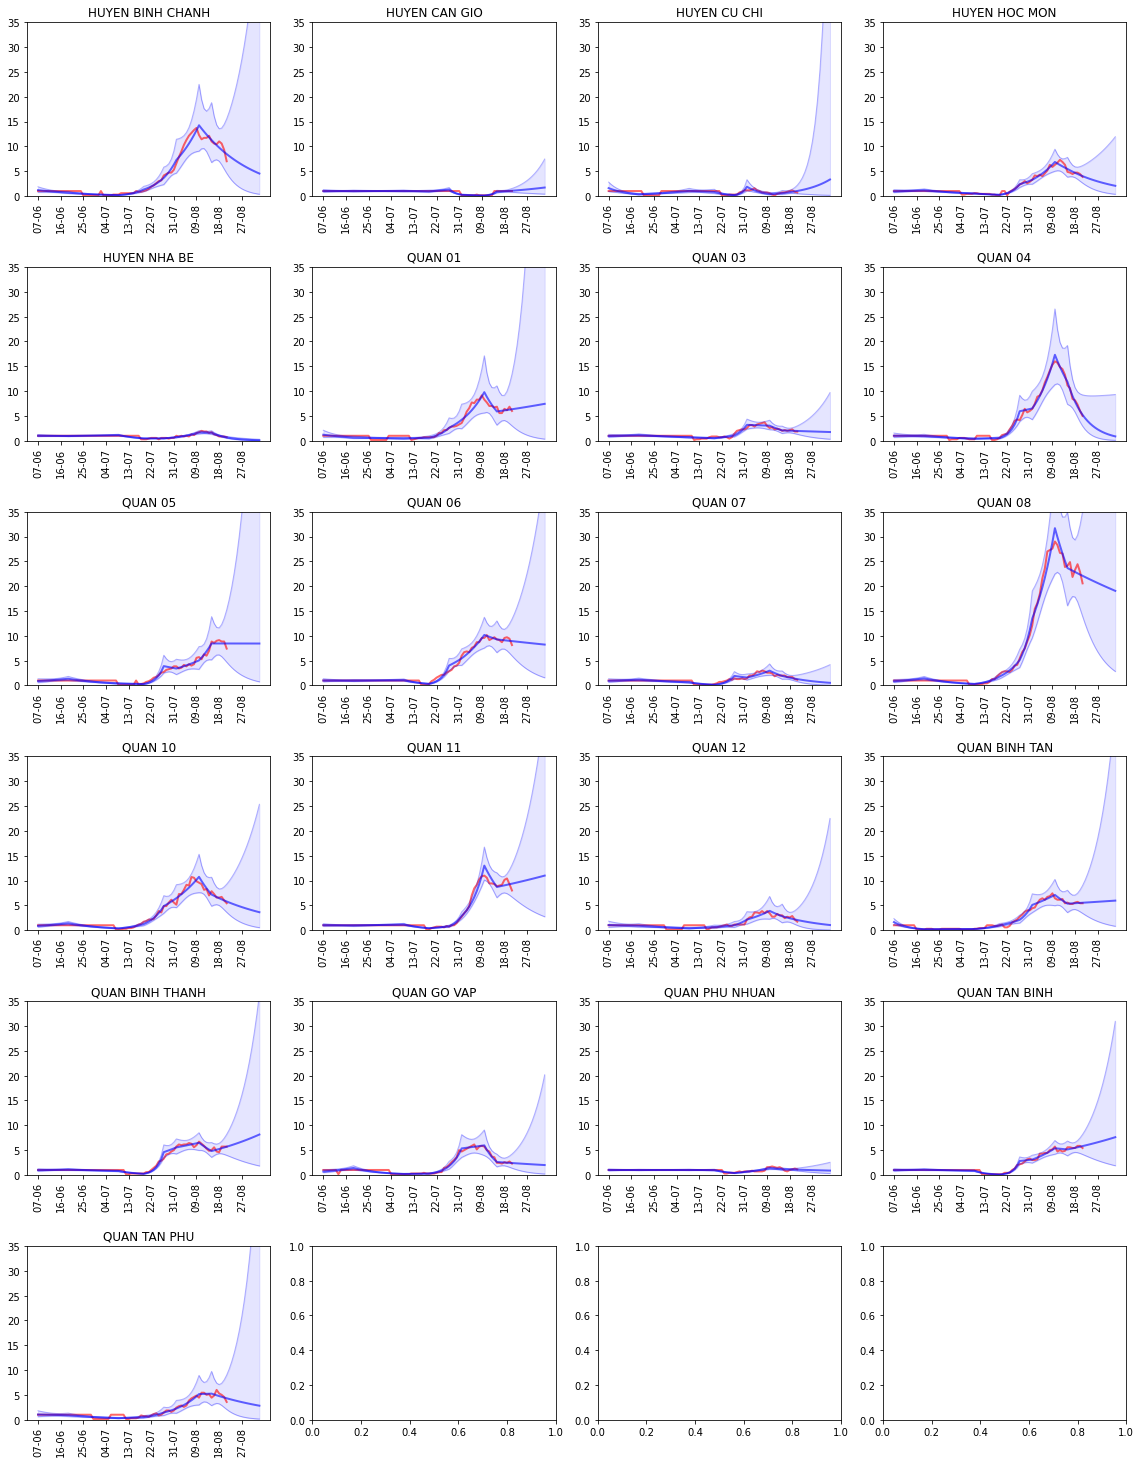

In [105]:
forecast_no_death_by_group(
    no_death_by_adh,
    no_death_col=no_death_col,
    group='addr_dist_home',
    forecast_horizon=forecast_horizon
)
plot_forecast_no_death_by_group(
    ylim=35,
    nrow=6,
    ncol=4,
    xstart=1,
    xend=24,

)

In [70]:
# plot_forecast_no_death_by_group(nrow=2, ncol=2, xstart=22, xend=23, ylim=4000, figsize=(16, 8))
np.exp(predicted_var_dict['quan03'])

array([1.02994014, 1.02357326, 1.01670868, 1.01265743, 1.00989823,
       1.00539133, 1.00403275, 1.00285251, 1.00326183, 1.00256369,
       1.00576949, 1.00787207, 1.01054487, 1.01444156, 1.0112715 ,
       1.00653988, 1.00373217, 1.00424558, 1.00602243, 1.00032321,
       1.00435717, 1.00967516, 1.01421781, 1.02215326, 1.00745547,
       1.00513365, 1.00321685, 1.00787715, 1.0108899 , 1.00706997,
       1.00623739, 1.01616022, 1.00210441, 0.99841661, 0.99678239,
       0.99057537, 1.00092758, 0.99935213, 0.99561888, 0.99381501,
       0.98607221, 1.00313058, 1.00712516, 1.017247  , 1.025246  ,
       1.00192308, 1.00033995, 0.99606804, 0.96561951, 0.96369509,
       0.96707403, 0.96784977, 0.96998159, 0.97747463, 0.98237126,
       0.988674  , 1.00049988, 1.0056109 , 1.0246786 , 1.00257382,
       1.01556558, 1.03016525, 1.0464371 , 1.06445344, 1.0932156 ,
       1.11515177, 1.13911992, 1.16523151, 1.1936096 , 1.22438978])

<ipython-input-111-7739b6621d2b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_report'] = pd.to_datetime(df.date_report)


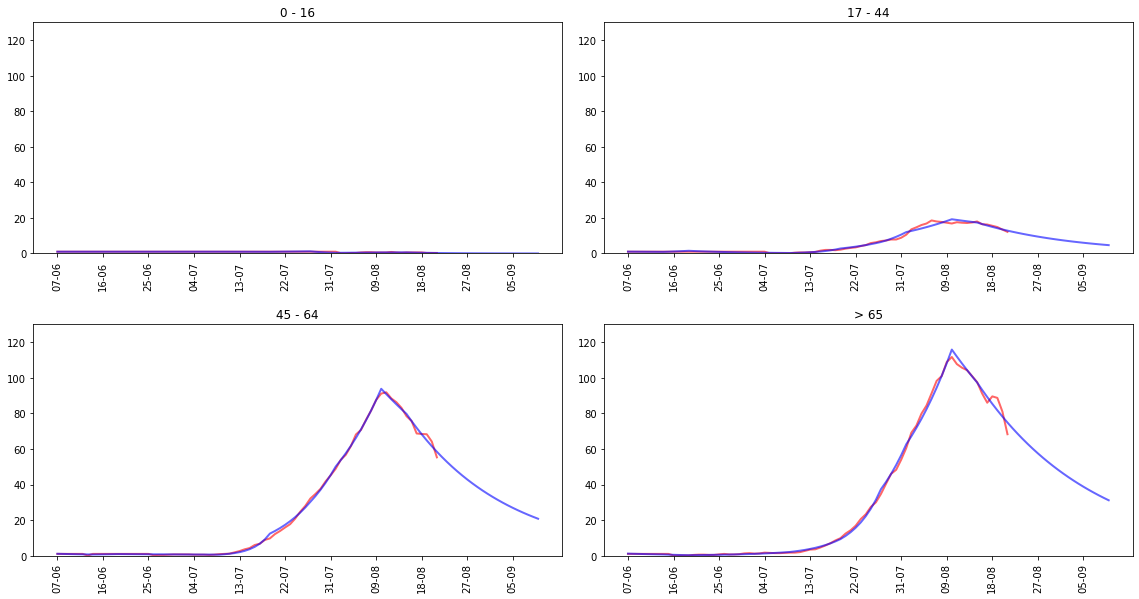

In [119]:
forecast_no_death_by_group(
    no_death_by_ag,
    no_death_col=no_death_col,
    group='age_group',
    forecast_horizon=forecast_horizon)
plot_forecast_no_death_by_group(nrow=2, ncol=2, xstart=8, xend=12, ylim=130, figsize=(16, 8))


<ipython-input-111-7739b6621d2b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_report'] = pd.to_datetime(df.date_report)


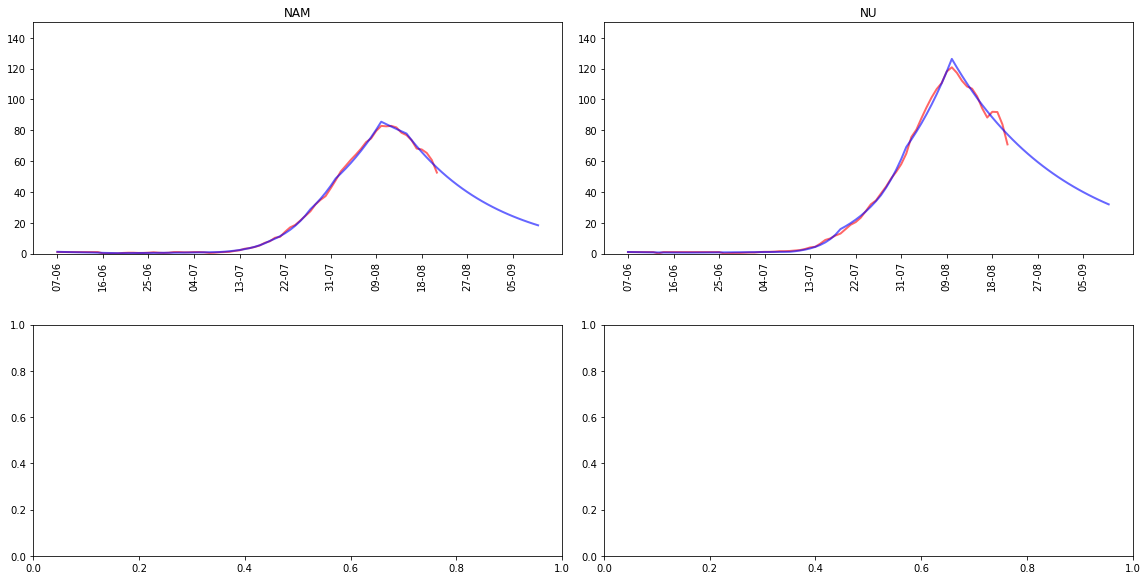

In [121]:
forecast_no_death_by_group(
    no_death_by_sex,
    no_death_col=no_death_col,
    group='sex',
    forecast_horizon=forecast_horizon)

plot_forecast_no_death_by_group(nrow=2, ncol=2, xstart=12, xend=14, ylim=150, figsize=(16, 8))


In [82]:
# y hat, ub, lb ngay 04/09
# foo_yhat = np.exp(pd.DataFrame(y_hat_dict))
# foo_ub = np.exp(pd.DataFrame(ub_dict))
# foo_lb = np.exp(pd.DataFrame(lb_dict))
# pd.to_datetime(x_hat_dict).strftime('%d-%m-%Y')[:-1]
# predicted_no_death = pd.concat([foo_yhat.loc[100], foo_ub.loc[100], foo_lb.loc[100]], axis=1)
# predicted_no_death.columns = ['y_hat', 'ci_lower', 'ci_upper']
# predicted_no_death
# predicted_no_death.to_csv(src / 'predicted-no-case-from-no-case-data' / 'predicted-no-case-2021-09-04.csv')
# xlabels_dict['tphcm'][100]

,y_hat,ci_lower,ci_upper
tphcm,7366.238947,10880.919662,4986.846509
quan01,461.425121,789.410227,269.711660
quan12,656.389784,1693.231225,254.452872
quanthuduc,129.357529,397.521478,42.094254
quan09,886.760415,4243.517714,185.304760
quangovap,43.668236,95.725347,19.920689
quanbinhthanh,337.129116,829.617696,136.998091
quantanbinh,1458.681604,2661.324240,799.508752
quantanphu,329.024258,772.369824,140.162082
quanphunhuan,158.305545,392.528037,63.844218


In [123]:
slope = pd.DataFrame(slope_dict).transpose()
slope.columns = pd.to_datetime(policy_change).strftime('%d-%m-%Y')[:-1]
r0 = np.exp(slope)

# slope.to_csv(src / 'predicted-no-death-from-no-death-data' / 'slope.csv')
# r0.to_csv(src / 'predicted-no-death-from-no-death-data' / 'r0.csv')
# slope
r0

,07-06-2021,31-05-2021,14-06-2021,19-06-2021,09-07-2021,19-07-2021,27-07-2021,01-08-2021,10-08-2021,15-08-2021
tphcm,1.028624,0.862312,0.921501,1.132283,1.204645,1.162973,1.102976,1.070496,0.968593,0.952919
quan01,1.009790,1.008554,0.996332,0.976579,0.975013,1.223350,1.091553,1.098891,0.903116,1.012396
quan03,1.039441,1.041681,1.006479,0.947420,0.987542,1.088298,1.246312,0.993741,0.927133,0.991114
quan04,1.026085,1.024433,0.995180,0.948051,1.009891,1.355574,1.015488,1.115187,0.927011,0.871955
quan05,1.100977,1.106887,1.016190,0.874310,1.005577,1.364512,0.980133,1.043704,1.109271,0.999815
quan06,0.991979,0.991535,0.998656,1.011308,0.884961,1.369344,1.062644,1.071665,0.981652,0.993755
quan08,1.119141,1.125321,1.016657,0.850870,1.248065,1.119596,1.223286,1.098353,0.943621,0.988593
quan07,1.048812,1.051598,1.007988,0.935621,0.886860,1.356146,0.967525,1.071488,0.915886,0.934696
0-16,0.999962,1.000151,0.999172,1.000587,0.994784,1.029883,0.791292,1.049425,1.011380,0.877422
17-44,1.004682,0.981843,1.106034,0.917533,1.263867,1.109379,1.132896,1.053613,0.979926,0.950798


In [132]:
pd.to_datetime(policy_change).strftime('%d-%m-%Y')[:-1]

Index(['27-05-2021', '31-05-2021', '14-06-2021', '19-06-2021', '09-07-2021',
       '19-07-2021', '01-08-2021', '15-08-2021'],
      dtype='object')

In [21]:
# TODO fix this plot
# Forecast no_case by adh
unique = list(no_case_by_adh.addr_dist_home.unique())
for u in unique:
    df = no_case_by_adh[no_case_by_adh.addr_dist_home == u]
    df.loc[:,'date_report'] = pd.to_datetime(df.date_report)
    forecast_horizon = 15
    policy_change = [df.date_report.min(), '2021-05-31', '2021-06-14', '2021-06-19', 
                     '2021-07-09', '2021-07-19', '2021-08-01', df.date_report.max()]

    output_dir = src / 'predicted-no-case-from-no-case-data'
    prefix_1 = 'predicted-no-case-'
    prefix_2 = 'by-adh-'
    filename = prefix_1 + prefix_2 + u.lower().replace(' ', '') + '.png'

    x = (df.date_report - df.date_report.min()) / pd.Timedelta(1, unit='d')
    y = df.no_case_ppop_rollmean7d.replace(0, np.nan).transform(math.log).fillna(0)
    x0 = (pd.to_datetime(policy_change) - df.date_report.min()) / pd.Timedelta(1, unit='d')
    xlabels = pd.date_range(
        df.date_report.min(),
        df.date_report.max() + pd.Timedelta(days=forecast_horizon-1)
    ).strftime('%d-%m')

    model = pwlf.PiecewiseLinFit(x, y)
    model.fit_with_breaks(x0)

    x_hat = np.arange(min(x), max(x) + forecast_horizon)
    y_hat = model.predict(x_hat)

    predicted_var = model.prediction_variance(x_hat)
    ub = y_hat + 1.96*np.sqrt(predicted_var)
    lb = y_hat - 1.96*np.sqrt(predicted_var)

    fig, ax = plt.subplots(figsize=(20, 6))
    ax.plot(x, np.exp(y), linewidth=3, color='red', alpha=0.6)
    ax.plot(x_hat, np.exp(y_hat), linewidth=3, color='blue', alpha=0.6)
    ax.plot(x_hat, np.exp(ub), linewidth=2, color='blue', alpha=0.3)
    ax.plot(x_hat, np.exp(lb), linewidth=2, color='blue', alpha=0.3)
    ax.set_ylabel('Số ca mới')
    ax.set_xlabel('Ngày')
    ax.set_xticks(x_hat)
    ax.set_xticklabels(xlabels)
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_title('Số ca mới & Số ca mới dự báo ' + u)
    for i in x0:
        ax.axvline(i, color='black', alpha=0.3)

    plt.savefig(
        output_dir / filename,
        transparent = True)
    plt.close(fig)

/home/kyo/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/kyo/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/kyo/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

/home/kyo/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/kyo/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/kyo/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [29]:
# Forecast no_case by adh
for key in y_hat_dict.keys():
    output_dir = src / 'predicted-no-case-from-no-case-data'
    prefix_1 = 'predicted-no-case-'
    prefix_2 = 'by-adh-'
    filename = prefix_1 + prefix_2 + plot_title_dict[key].lower().replace(' ', '') + '.png'
    x = x_dict[key]
    y = y_dict[key]
    x_hat = x_hat_dict[key]
    y_hat = y_hat_dict[key]
    ub = ub_dict[key]
    lb = lb_dict[key]
    title = plot_title_dict[key]
    xlabels = xlabels_dict[key]

    fig, ax = plt.subplots(figsize=(20, 6))
    ax.plot(x, np.exp(y), linewidth=3, color='red', alpha=0.6)
    ax.plot(x_hat, np.exp(y_hat), linewidth=3, color='blue', alpha=0.6)
    ax.plot(x_hat, np.exp(ub), linewidth=2, color='blue', alpha=0.3)
    ax.plot(x_hat, np.exp(lb), linewidth=2, color='blue', alpha=0.3)
    ax.set_ylabel('Số ca mới')
    ax.set_xlabel('Ngày')
    ax.set_xticks(x_hat)
    ax.set_xticklabels(xlabels)
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_title('Số ca mới & Số ca mới dự báo ' + plot_title_dict[key])
    for i in x0:
        ax.axvline(i, color='black', alpha=0.3)

    plt.savefig(
        output_dir / filename,
        transparent = True)
    plt.close(fig)

In [25]:
for key in y_hat_dict.keys():
    print(key)

tphcm
quan01
quan12
quanthuduc
quan09
quangovap
quanbinhthanh
quantanbinh
quantanphu
quanphunhuan
quan02
quan03
quan10
quan11
quan04
quan05
quan06
quan08
quanbinhtan
quan07
huyencuchi
huyenhocmon
huyenbinhchanh
huyennhabe
huyencangio


In [30]:
# np.exp(y_hat)[82]
# np.exp(ub)[82]
# np.exp(lb)[82]

In [49]:
y_hat[82]

7.913757636719259